# PPO
---

### 1. Import the Necessary Packages

In [1]:
from model.ppo_3 import PPO
from env.wrappers import *
from env.ant_disturbances import *
from utils.logger import WandbSummaryWritter
import torch
from networks.mlp import MLP, DummyEncoder

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
# hyperparameters = {
#     'timesteps_per_batch': 1024 ,                # Number of timesteps to run per batch
#     'max_timesteps_per_episode': 1200,           # Max number of timesteps per episode
#     'n_updates_per_iteration': 5,                # Number of times to update actor/critic per iteration
#     'lr': 2.5e-4 ,                                # Learning rate of actor optimizer
#     'gamma': 0.95,                               # Discount factor to be applied when calculating Rewards-To-Go
# }
# hyperparameters = {'gamma': 0.999, 'lr_gamma': 0.995,
#                    'max_timesteps_per_episode': 1200,'lr': 0.005 }

hyperparameters = {}

misc_hyperparameters = {
    'env': Ant,
    'activation': torch.nn.ReLU,
    'base_encoder_class': DummyEncoder,
    'env_args': {
        'env_class': Ant_Stiffness,
        'known_disturbances':True,
        'min_stiff':0,
        'max_stiff':10,
    }
}

Initialise wandb session in the code cell below.

In [3]:
LOG = True
if LOG:
    logger = WandbSummaryWritter(project='ant', config =misc_hyperparameters['env']().load_hyperparameters())
else:
    logger=None

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pmsaraiva2712 (pmsaraiva2712-tum). Use `wandb login --relogin` to force relogin


Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [4]:
checkpoint = 'trained_models/ant-45'
# checkpoint = 'ppo_checkpoints/ant-1'
LOAD_MODEL = False

ppo = PPO(logger, **hyperparameters, **misc_hyperparameters)

if LOAD_MODEL:
    ppo.policy.load_state_dict(torch.load(checkpoint + "/ppo_policy_500.pth"))
    # ppo.adpt_module.load_state_dict(torch.load(checkpoint + "/adp_model.pth"))
    # ppo.adapt_policy.set_policy(ppo.policy)

In [39]:
from networks.LSTMAdaptiveActorCritic import LSTMAdaptiveActorCritic
ppo_10 = PPO(logger, **hyperparameters, **misc_hyperparameters, history_len = 10)
ppo_30 = PPO(logger, **hyperparameters, **misc_hyperparameters, history_len = 30)
ppo_40 = PPO(logger, **hyperparameters, **misc_hyperparameters, history_len = 30)
ppo_lstm = PPO(logger, **hyperparameters, **misc_hyperparameters, adaptive_class = LSTMAdaptiveActorCritic)

### 3. Train the Model

Train model for specified amount of timestamps.

In [5]:
ppo.train()
# ppo_lstm.train_adaptive_module2()
# ppo_10.train_adaptive_module()
# ppo_30.train_adaptive_module()
# ppo_40.train_adaptive_module()


-------------------- Iteration 1/387 --------------------
Average Episodic Return: -298.56
Average Actor Loss: -0.15543
Average Critic Loss: 726.1709104860586
Average KL Divergence: 0.009798922482733317
Iteration took: 19.82 secs, of which rollout took 16.1 secs and gradient updates took 3.7 secs
Current learning rate: 0.001
------------------------------------------------------


-------------------- Iteration 2/387 --------------------
Average Episodic Return: -334.91
Average Actor Loss: -0.15308
Average Critic Loss: 612.5747862663438
Average KL Divergence: 0.009241588341142125
Iteration took: 19.95 secs, of which rollout took 16.2 secs and gradient updates took 3.75 secs
Current learning rate: 0.001
------------------------------------------------------


-------------------- Iteration 3/387 --------------------
Average Episodic Return: -320.59
Average Actor Loss: -0.15154
Average Critic Loss: 629.2471168442695
Average KL Divergence: 0.009162655957657629
Iteration took: 20.04 secs,

KeyboardInterrupt: 

### 4. Evaluate the Model

Run multiple episodes from pretrained model.

In [8]:
import os
i = 5
path = f"C:\\Users\\pmsar\\git\\tum-adlr-ws25-16\\ppo_checkpoints\\ant_test_unknown{i}"
os.makedirs(path, exist_ok=True)
torch.save(ppo.policy.state_dict(), path + "\\base.pth")
# torch.save(ppo.adpt_module.state_dict(), path + "\\adpt.pth")
# ppo.test(False)

In [32]:

import numpy as np
MAX_IT = 100
dist = np.zeros(MAX_IT)
val_t = np.zeros(MAX_IT)
val_rew = np.zeros(MAX_IT)
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, **ppo.env_args)
for i in  range(0, MAX_IT):
        obs, done = env.reset()
        model = env.envs[0].model
        t = 1
        reward = 0
        dist[i] = obs[0, -1]
        while not done[0] and t < 1_000:
            action = ppo.policy.sample_action(torch.Tensor(obs))
            obs, rew, done = env.step(action.numpy())
            t+=1
            reward+=rew
        val_t[i] = t
        val_rew[i] =reward
print(np.mean(val_t), np.mean(val_rew))
#752.86 1538.6648483656134

920.55 725.1482438696507


[0.70416131 2.08918718 6.71143517 3.58646781 2.54163649 2.95290588
 8.48669795 1.36621331 7.08910997 5.52819977 2.96510144 2.56206944
 6.11513711 0.8159418  0.05184863 1.94273954 3.96783827 0.50768531
 8.86617149 0.27616772 4.38474123 6.72026135 3.28152667 1.55041617
 9.81840888 8.38933502 8.60404618 2.50251361 3.03265515 3.26651242
 8.27869004 2.71542916 9.6525183  4.57265162 8.42023075 1.94380034
 6.99512211 1.38353092 1.32745422 7.14595104 0.41067517 3.98820901
 4.33520738 7.44042643 2.50860527 1.84333674 0.80872967 4.28314475
 6.88499901 0.58193596 9.15213728 4.4235223  2.39787359 0.9387329
 1.82865997 9.34613997 6.38270594 5.16696257 6.57111329 4.35672899
 7.30039317 0.47716128 5.6603721  1.58646448 1.20164648 3.41879667
 0.91799066 0.94156988 3.11413309 9.79510529 1.7533027  0.17161102
 7.63364423 3.46304321 4.64673813 6.49773683 0.48058924 9.49145732
 8.86680387 2.60893623 0.1530454  9.33436308 5.01039884 5.39377448
 6.83963769 6.15851164 9.43891605 9.44251597 8.67198934 6.36403

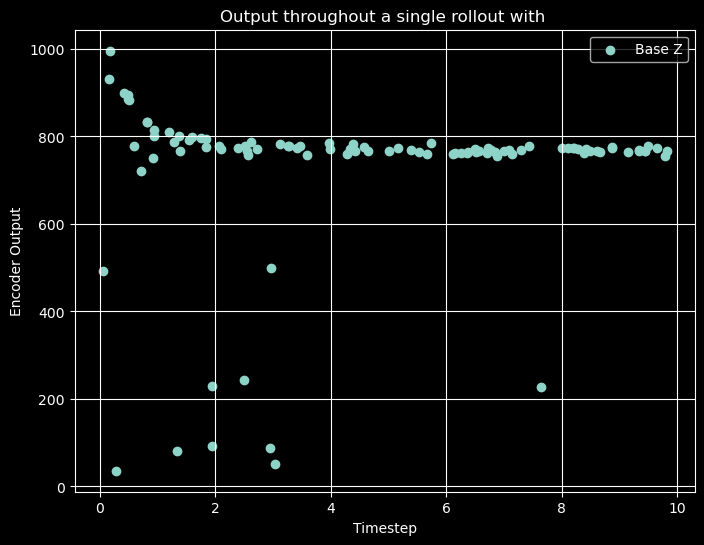

In [33]:
import matplotlib.pyplot as plt

# wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()
# indices = range(len(wind_vals))
print(dist)

plt.figure(figsize=(8, 6))
plt.scatter(dist, val_rew, label="Base Z")

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with ")
plt.legend()
plt.grid(True)

plt.show()

In [17]:
import os
os.environ["MUJOCO_GL"] = "wgl"
env.close()
ppo.policy.cpu()
env = ppo.env_class(num_envs=1, render_mode="human", **ppo.env_args)
while True:
    obs, done = env.reset()
    model = env.envs[0].model
    t = 1
    while not done[0] and t < 1_000:
        action = ppo.policy.sample_action(torch.Tensor(obs))
        obs, _, done = env.step(action.numpy())
        t+=1

KeyboardInterrupt: 

In [34]:
ppo.adapt_policy.clear_history()

wind_vals = []
base_z = []
adpt_z = []
ppo.policy.to(ppo.device)
env = ppo.env_class(num_envs=1, render_mode='human', **ppo.env_args)
obs, done = env.reset()

reward = 0
t = 0
while not done[0] and t < 1_000:
    wind_vals.append(obs[0, -1])

    obs_tensor = torch.tensor(obs, dtype=torch.float32).to(ppo.device)
    action,_ = ppo.adapt_policy.sample_action(obs_tensor)

    base_output = ppo.policy.encoder(obs_tensor).detach().cpu().numpy().flatten()[0]
    adpt_output = ppo.adapt_policy.encode(obs_tensor).detach().cpu().numpy().squeeze()[-1]

    base_z.append(base_output)
    adpt_z.append(adpt_output)
    obs, rew, done = env.step(action.cpu().numpy())
    reward += rew
    t+=1
    if t % 1000 == 0:
        print(t, reward)
print(t, reward)
print(wind_vals[0], base_z[0])

1000 [779.45903106]
1000 [779.45903106]
2.7396112732113376 0.61942077


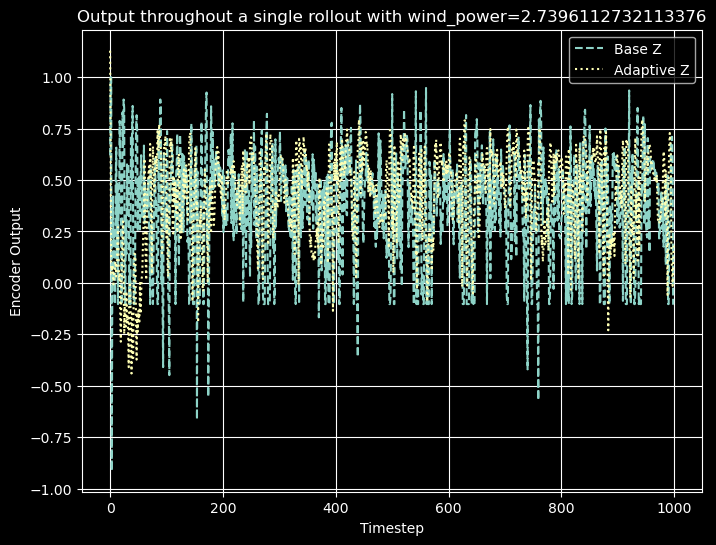

In [35]:
import matplotlib.pyplot as plt

# wind_vals, base_z, adpt_z = ppo.validate_encoders_single_rollout()
indices = range(len(wind_vals))

plt.figure(figsize=(8, 6))
plt.plot(indices, base_z, label="Base Z", linestyle='--')
plt.plot(indices, adpt_z, label="Adaptive Z", linestyle=':')

plt.xlabel("Timestep")
plt.ylabel("Encoder Output")
plt.title(f"Output throughout a single rollout with wind_power={wind_vals[0]}")
plt.legend()
plt.grid(True)

plt.show()

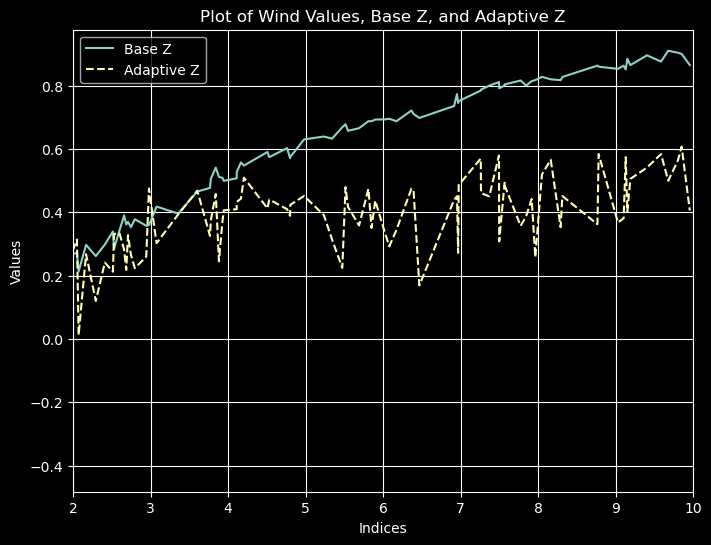

In [37]:
import numpy as np
t_winds, b_z, a_z = ppo.validate_encoders(100, 150)
sorted_indices = np.argsort(t_winds)
plt.figure(figsize=(8, 6))
plt.plot(t_winds[sorted_indices], b_z[sorted_indices], label="Base Z")
plt.plot(t_winds[sorted_indices], a_z.cpu().numpy()[sorted_indices], label="Adaptive Z", linestyle='--')

plt.xlabel("Indices")
plt.xlim(2, 10)
plt.ylabel("Values")
plt.title("Plot of Wind Values, Base Z, and Adaptive Z")
plt.legend()
plt.grid(True)

plt.show()

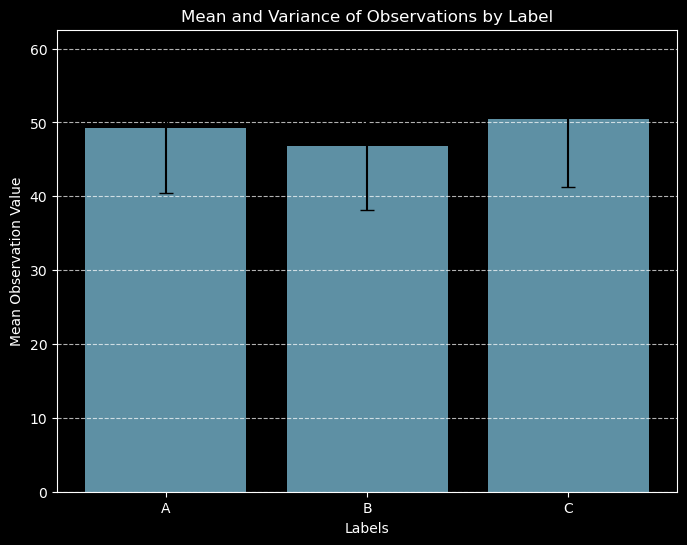

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate example data
np.random.seed(42)
n = 100
observations = np.random.randn(n) * 10 + 50  # Random observations
labels = np.random.choice(['A', 'B', 'C'], size=n)  # Random labels

# Convert labels to a PyTorch tensor
labels_tensor = torch.tensor([ord(label) for label in labels])  # Convert to numeric values for grouping
observations_tensor = torch.tensor(observations, dtype=torch.float32)

# Find unique labels
unique_labels = np.unique(labels)

# Compute mean and variance using PyTorch
means = []
variances = []

for label in unique_labels:
    mask = labels_tensor == ord(label)  # Boolean mask for label grouping
    group = observations_tensor[mask]  # Select corresponding observations
    means.append(torch.mean(group).item())  # Compute mean
    variances.append(torch.var(group, unbiased=False).item())  # Compute variance

# Convert lists to numpy arrays
means = np.array(means)
variances = np.array(variances)
std_devs = np.sqrt(variances)  # Standard deviations for error bars

# Plot
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, means, yerr=std_devs, capsize=5, color='skyblue', alpha=0.7)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Mean Observation Value")
plt.title("Mean and Variance of Observations by Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()